# Inference Requests Parallel Workload Optimization

This notebook demonstrates how to optimize the parallelism performance of multiple requests pipeline. In some scenarios, we have to run many inference requests with same model and concatenate the outputs of them for visualization. For example: multiple requests of recognition network will be implemented to identify each detected object separatly. The results of detection network are used to crop the original input image and produce the inputs for each recognition request. In this case, we can run these inference request synchronously (one by one), or make them in parallel to improve the throughputs.


![image](https://github.com/OpenVINO-dev-contest/YOLOv7_OpenVINO_cpp-python/assets/91237924/b5124cfb-983b-4f59-ac2f-d74f6a2e1b02)


## Imports

In [6]:
import sys
import cv2
import time
import psutil
import numpy as np
from openvino.runtime import Core, AsyncInferQueue
from IPython import display
sys.path.append("../utils")
import notebook_utils as utils

## Download the Models
We will use pre-trained models from OpenVINO's [Open Model Zoo](https://docs.openvino.ai/nightly/model_zoo.html) to start the test.

Use `omz_downloader`, which is a command-line tool from the `openvino-dev` package. It automatically creates a directory structure and downloads the selected model. This step is skipped if the model is already downloaded. The selected model comes from the public directory, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

> **NOTE**: Using a model outside the list can require different pre- and post-processing.

In this case, [person detection model]( https://docs.openvino.ai/latest/omz_models_model_person_detection_0202.html) is deployed to detect the person in each frame of the video, and [object recognition models]( https://docs.openvino.ai/latest/omz_models_model_person_attributes_recognition_crossroad_0234.html#doxid-omz-models-model-person-attributes-recognition-crossroad-0234) is used to recognize the attributes of detected people.


If you want to download another model (`person-detection-xxx` from [Object Detection Models list](https://docs.openvino.ai/latest/omz_models_group_intel.html#object-detection-models), `person-reidentification-retail-xxx` from [Object Recognition Models list](https://docs.openvino.ai/latest/omz_models_group_intel.html#object-recognition-models)), replace the name of the model in the code below.

In [7]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "person-detection-0202"
precision = "FP16"
det_model_path = (
    f"model/intel/{model_name}/{precision}/{model_name}.xml"
)
download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--precision {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading person-detection-0202 ||################

========== Retrieving model/intel/person-detection-0202/FP16/person-detection-0202.xml from the cache

========== Retrieving model/intel/person-detection-0202/FP16/person-detection-0202.bin from the cache



In [8]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "person-attributes-recognition-crossroad-0234"
precision = "FP16"
rec_model_path = (
    f"model/intel/{model_name}/{precision}/{model_name}.xml"
)
download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--precision {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading person-attributes-recognition-crossroad-0234 ||################

========== Retrieving model/intel/person-attributes-recognition-crossroad-0234/FP16/person-attributes-recognition-crossroad-0234.xml from the cache

========== Retrieving model/intel/person-attributes-recognition-crossroad-0234/FP16/person-attributes-recognition-crossroad-0234.bin from the cache



## Load, Configure and Run models
Define a common class for model loading, configuration and predicting.

There are four main steps for OpenVINO model initialization, and they are required to run for only once before inference loop.
 1. Initialize OpenVINO Runtime.
 2. Read the network from `*.bin` and `*.xml` files (weights and architecture).
 3. Compile the model for device with configuration.
 4. Get input and output names of nodes.

In this case, we can put them all in a class constructor function.

In [11]:
class Module:
    def __init__(self, core, model_path, type):
        """
        Read the model file
        
        Parameters
        ----------
        core: OpenVINO core
        model_path: path of inference model
        type: type of model
        """
        self.core = core
        self.model = core.read_model(model_path)
        self.type = type
        self.active_requests = 0
        self.clear()

    def deploy(self, device, config={}, max_requests=1):
        """
        Compile the model and create inference queue
        
        Parameters
        ----------
        device: device name
        config: configuration on compiled model
        type: maximum of inference requests can be created
        """
        self.max_requests = max_requests
        compiled_model = self.core.compile_model(self.model, device, config)
        # we can print some low-level hardware configuration of compile model on CPU
        if device == 'CPU':
            print(f"***** CPU cofigurations on {self.type} model  ****")
            NUM_STREAMS = compiled_model.get_property('NUM_STREAMS')
            print(f"> the number of streams: {NUM_STREAMS}")
            NUM_THREADS = compiled_model.get_property('INFERENCE_NUM_THREADS')
            print(f"> the number of inference threads: {NUM_THREADS}")
            CPU_PINNING = compiled_model.get_property('ENABLE_CPU_PINNING')
            print(f"> threads are binded to CPU processors: {CPU_PINNING}")
            CORE_TYPE = compiled_model.get_property('SCHEDULING_CORE_TYPE')
            print(f"> the type of core is: {CORE_TYPE}")
            HYPER_THREADING = compiled_model.get_property('ENABLE_HYPER_THREADING')
            print(f"> hyper-threading is on: {HYPER_THREADING}")
        self.output_tensor = compiled_model.outputs[0]
        self.infer_queue = AsyncInferQueue(compiled_model, self.max_requests)
        self.infer_queue.set_callback(self.completion_callback)

    def completion_callback(self, infer_request, id):
        """
        Define the postprocess function for each request
        
        Parameters
        ----------
        infer_request: inference request
        id: id of inference request
        """
        self.outputs[id] = infer_request.results[self.output_tensor]

    def enqueue(self, input):
        """
        Start the inference request in queue
        
        Parameters
        ----------
        input: input data
        """
        if self.max_requests <= self.active_requests:
            print('Processing request rejected - too many requests')
            return False

        self.infer_queue.start_async(input, self.active_requests)
        self.active_requests += 1
        return True

    def wait(self):
        """
        Wait for the all requests in queue are finished
        """
        if self.active_requests <= 0:
            return
        self.infer_queue.wait_all()
        self.active_requests = 0

    def get_outputs(self):
        """
        Extract the results from model outputs
        """
        self.wait()
        return [v for _, v in sorted(self.outputs.items())]

    def clear(self):
        """
        Clear the output list
        """
        self.outputs = {}

    def infer(self, inputs):
        """
        Run inference and do postprocess
        
        Parameters
        ----------
        inputs: input data
        """
        self.clear()
        self.start_async(*inputs)
        return self.postprocess()

In [12]:
class Detector(Module):
    def __init__(self, core, model, type, confidence_threshold=0.5):
        """
        Read the model file
        
        Parameters
        ----------
        core: OpenVINO core
        model_path: path of inference model
        type: type of model
        confidence_threshold: threshold for detection results
        """
        super(Detector, self).__init__(core, model, type)
        self.input_tensor_name = self.model.inputs[0].get_any_name()
        self.input_shape = self.model.inputs[0].shape
        self.confidence_threshold = confidence_threshold

    def preprocess(self, frame):
        """
        Preprocess function
        
        Parameters
        ----------
        frame: input image
        """
        self.input_size = frame.shape
        _, _, h, w = self.input_shape
        resized_image = cv2.resize(frame, (w, h))
        resized_image = resized_image.transpose((2, 0, 1))
        resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
        return resized_image

    def start_async(self, frame):
        """
        Do prepreocess and push the processed image into the inference request queue
        
        Parameters
        ----------
        frame: input image
        """
        input = self.preprocess(frame)
        self.enqueue(input)

    def enqueue(self, input):
        return super(Detector, self).enqueue({self.input_tensor_name: input})

    def postprocess(self):
        """
        Postprocess
        """
        outputs = self.get_outputs()[0]
        # outputs shape is [N_requests, 1, 1, N_max_faces, 7]

        boxes = []
        for output in outputs[0][0]:
            _, image_id, confidence, xmin, ymin, xmax, ymax = output
            if confidence < self.confidence_threshold:
                break # results are sorted by confidence decrease
            
            xmin = int(max((xmin * self.input_size[1]), 10))
            ymin = int(max((ymin * self.input_size[0]), 10))
            xmax = int(min((xmax * self.input_size[1]), self.input_size[1] - 10))
            ymax = int(min((ymax * self.input_size[0]), self.input_size[0] - 10))
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes
    
class Recognizer(Module):
    def __init__(self, core, model, type):
        super(Recognizer, self).__init__(core, model, type)
        self.input_tensor_name = self.model.inputs[0].get_any_name()
        self.input_shape = self.model.inputs[0].shape
        self.output_shape = self.model.outputs[0].shape

    def preprocess(self, frame):
        """
        Preprocess
        
        Parameters
        ----------
        frame: input image
        """
        self.input_size = frame.shape
        _, _, h, w = self.input_shape
        resized_image = cv2.resize(frame, (w, h))
        resized_image = resized_image.transpose((2, 0, 1))
        resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
        return resized_image

    def start_async(self, frame, inputs):
        """
        Crop the input image and push these cropped image into the inference request queue
        
        Parameters
        ----------
        frame: input image
        """
        for input in inputs:
            crop_image = frame[input[1]:input[3], input[0]:input[2]]
            input = self.preprocess(crop_image)
            self.enqueue(input)

    def enqueue(self, input):
        return super(Recognizer, self).enqueue({self.input_tensor_name: input})

    def postprocess(self):
        """
        Postprocess
        """
        outputs = self.get_outputs()
        return outputs

## Initialize models object

In [13]:
core = Core()
detector = Detector(core, det_model_path, type="detection")
recognizer = Recognizer(core, rec_model_path, type="recognition")

## Load test video

In [14]:
video_path = "../data/video/people.mp4"

## Set-up the test pipeline

In [15]:
class benchmark:
    def __init__(self, source,  detector=detector, recognizer=recognizer, config={'device':'CPU', 'det':{}, 'rec':{}}):
        """
        Compile the model and create inference queue
        
        Parameters
        ----------
        source: input video
        detector: detection model object
        recognizer: recognition model object
        config: compiled model configuration
        """
        self.source = source
        self.detector = detector
        self.recognizer = recognizer
        self.detector.deploy(config['device'], config['det'])
        self.recognizer.deploy(config['device'], config['rec'], max_requests=56)
        
    def pipeline(self, visual, flip=False, fps=30, skip_first_frames=0):
        """
        Run inference pipeline on input video
        
        Parameters
        ----------
        visual: whether to show visualization results
        flip: to be used by VideoPlayer function for flipping capture image
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video.
        """
        # Create infer requests queue
        player = None
        try:
            # Create a video player
            player = utils.VideoPlayer(self.source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
            # Start capturing
            player.start()
            time_cost = 0
            it = 0
            while True:
                # Capture frame
                frame = player.next()
                if frame is None:
                    break
                it = it + 1
                # detection and recognition model are running sychronously
                rois = self.detector.infer((frame,))
                start_time = time.time()
                recognition = self.recognizer.infer((frame, rois))
                time_cost = time_cost+ time.time() - start_time
                if visual == True:
                    for i in range(len(recognition)):
                        cv2.rectangle(frame, (rois[i][0], rois[i][1]), (rois[i][2], rois[i][3]), (0, 255, 0), 2)
                        cv2.putText(frame, "is_male: "+str(recognition[i][0][0]), (rois[i][0], rois[i][1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 3)
                    _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                    # Create IPython image
                    i = display.Image(data=encoded_img)
                    # Display the image in this notebook
                    display.clear_output(wait=True)
                    display.display(i)
        except KeyboardInterrupt:
            print("Interrupted")
        # Any different error
        except RuntimeError as e:
            print(e)
        finally:
            fps = it / time_cost
            player.stop()
            return fps
        
    def run(self, loop=5, visual=False):
        """
        Run test for multiple loop
        
        Parameters
        ----------
        loop: iterations of single test
        visual: whether to show visualization results
        """
        cum_fps = 0
        for i in range(loop):
            fps = self.pipeline(visual)
            cum_fps = cum_fps + fps
        avg_fps = cum_fps / loop
        print(f"average fps: {avg_fps:.2f} fps")
        return avg_fps

## Hardware information

In [16]:
CORE_NUM = psutil.cpu_count()
PHY_CORE_NUM = psutil.cpu_count(logical=False)
print(f"The total number of cores is {CORE_NUM}, including {PHY_CORE_NUM} physical cores")

for device in core.available_devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")
    
    if device_name == 'CPU':
        CORE_NUM = psutil.cpu_count()
        PHY_CORE_NUM = psutil.cpu_count(logical=False)
        print(f"The total number of cores is {CORE_NUM}, including {PHY_CORE_NUM} physical cores")

The total number of cores is 112, including 56 physical cores
CPU: Intel(R) Xeon(R) Gold 6348 CPU @ 2.60GHz
GPU: Intel(R) Data Center GPU Flex 170 (dGPU)


## Create a list to collect configurations and performance results

In [17]:
configs = []
results = []

## Run benchmark with different configurations

### 1. No configuration

We can leave all of the configuration default, and set the benchmark results of it as baseline data.

In [18]:
config_1 = {'device':'CPU', 'det':{}, 'rec':{}}
test_1 = benchmark(source=video_path, config=config_1)
result_1 = test_1.run(visual=False)
configs.append(str(config_1))
results.append(result_1)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on recognition model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 22.33 fps


### 2. High-level Performance Hints

The `Performance Hints` express a target scenario with a single config key and let the device configure itself in response.Throughput and latency are some of the most widely used metrics that measure the overall performance of an application. Therefore, in order to ease the configuration of the device, OpenVINO offers two dedicated hints, namely `{"PERFORMANCE_HINT": "THROUGHPUT"}` and `{"PERFORMANCE_HINT": "LATENCY"}`. In `"LATENCY"` mode, sysem will leverage more resource on a single inference request, and in `"THROUGHPUT"` model, hareware resource will be separated into different requests, to maxmum the throughput of parallel requests.

 Since the detection model is an independent workload with single request, the hint of this model can be set as `"LATENCY"` model. For recognition model, we can do some comparason to identitfy which hint is better, because the peroformance can be various depending on the device and network architecture.

In [19]:
config_2 = {'device':'CPU', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'rec':{"PERFORMANCE_HINT":"LATENCY"}}
test_2 = benchmark(source=video_path, config=config_2)
result_2 = test_2.run(visual=False)
configs.append(str(config_2))
results.append(result_2)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on recognition model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 23.97 fps


In [20]:
config_3 = {'device':'CPU', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'rec':{"PERFORMANCE_HINT":"THROUGHPUT"}}
test_3 = benchmark(source=video_path, config=config_3)
result_3 = test_3.run(visual=False)
configs.append(str(config_3))
results.append(result_3)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on recognition model  ****
> the number of streams: 56
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 16.98 fps


Batching is a straightforward way of leveraging the compute power of GPU and saving on communication overheads. we can enable `Automatic Batching` to improve device utilization by grouping inference requests together. With `Automatic Batching`, gathering the input and scattering the output from the individual inference requests required for the batch happen transparently, without affecting the application code.These 2 ways are provided for the user to enable the BATCH devices explicitly or implicitly, Batching is “implicitly” triggered on the GPU with config = `{"PERFORMANCE_HINT": "THROUGHPUT"}` , and `"BATCH:GPU(16)"` can explicitly load BATCH device and tell it to apply GPU device with batch size = 16.

`Automatic Batching` primarily targets the existing code written for inferencing many requests, each instance with the batch size 1. To get corresponding performance improvements, the application must be running multiple inference requests simultaneously.

In [25]:
config_4 = {'device':'BATCH:GPU(4)', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'rec':{"PERFORMANCE_HINT":"THROUGHPUT"}}
test_4 = benchmark(source=video_path, config=config_4)
result_4 = test_4.run(visual=False)
configs.append(str(config_4))
results.append(result_4)

average fps: 1.27 fps


### 3. Further Low-Level Implementation

Besides Performance Hints, we can still implement some `low-level configuration` to further improve the performance according to task scenarios. For example, we can try to change the number of streams and number of threads to find out a best configuration for your device and network. 

![image](https://github.com/OpenVINO-dev-contest/YOLOv7_OpenVINO_cpp-python/assets/91237924/119e5aa8-0199-4456-90f8-bf9583e706df)

> - **Streams**: 
Internally, every device implements a queue, which acts as a buffer, storing the inference requests until retrieved by the device at its own pace. The devices may actually process multiple inference requests in parallel in order to improve the device utilization and overall throughput. This configurable method of this device-side parallelism is commonly referred as streams. The larger stream number, the larger number of parallel request is permitted. For example, 4 streams mean 4 inference requests can be run parellel on CPU. Please notes that the maxmum number of streams is equal to the number of CPU processors.

> - **Threads**: 
Threads means the minmum unit of CPU resource in inference for a compliled model. The threads will be equally allocated to each stream. For example if the tatal number of threads is 16 and number of stream is 4, the threads allocated to each stream will be 4.

In [22]:
config_5 = {'device':'CPU', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'rec':{"NUM_STREAMS":7,'INFERENCE_NUM_THREADS':56}}
test_5 = benchmark(source=video_path, config=config_5)
result_5 = test_5.run(visual=False)
configs.append(str(config_5))
results.append(result_5)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on recognition model  ****
> the number of streams: 7
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 28.74 fps


In [23]:
config_6 = {'device':'CPU', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'rec':{"NUM_STREAMS":14,'INFERENCE_NUM_THREADS':56}}
test_6 = benchmark(source=video_path, config=config_6)
result_6 = test_6.run(visual=False)
configs.append(str(config_6))
results.append(result_6)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on recognition model  ****
> the number of streams: 14
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 33.55 fps


## Benchmark results visulization

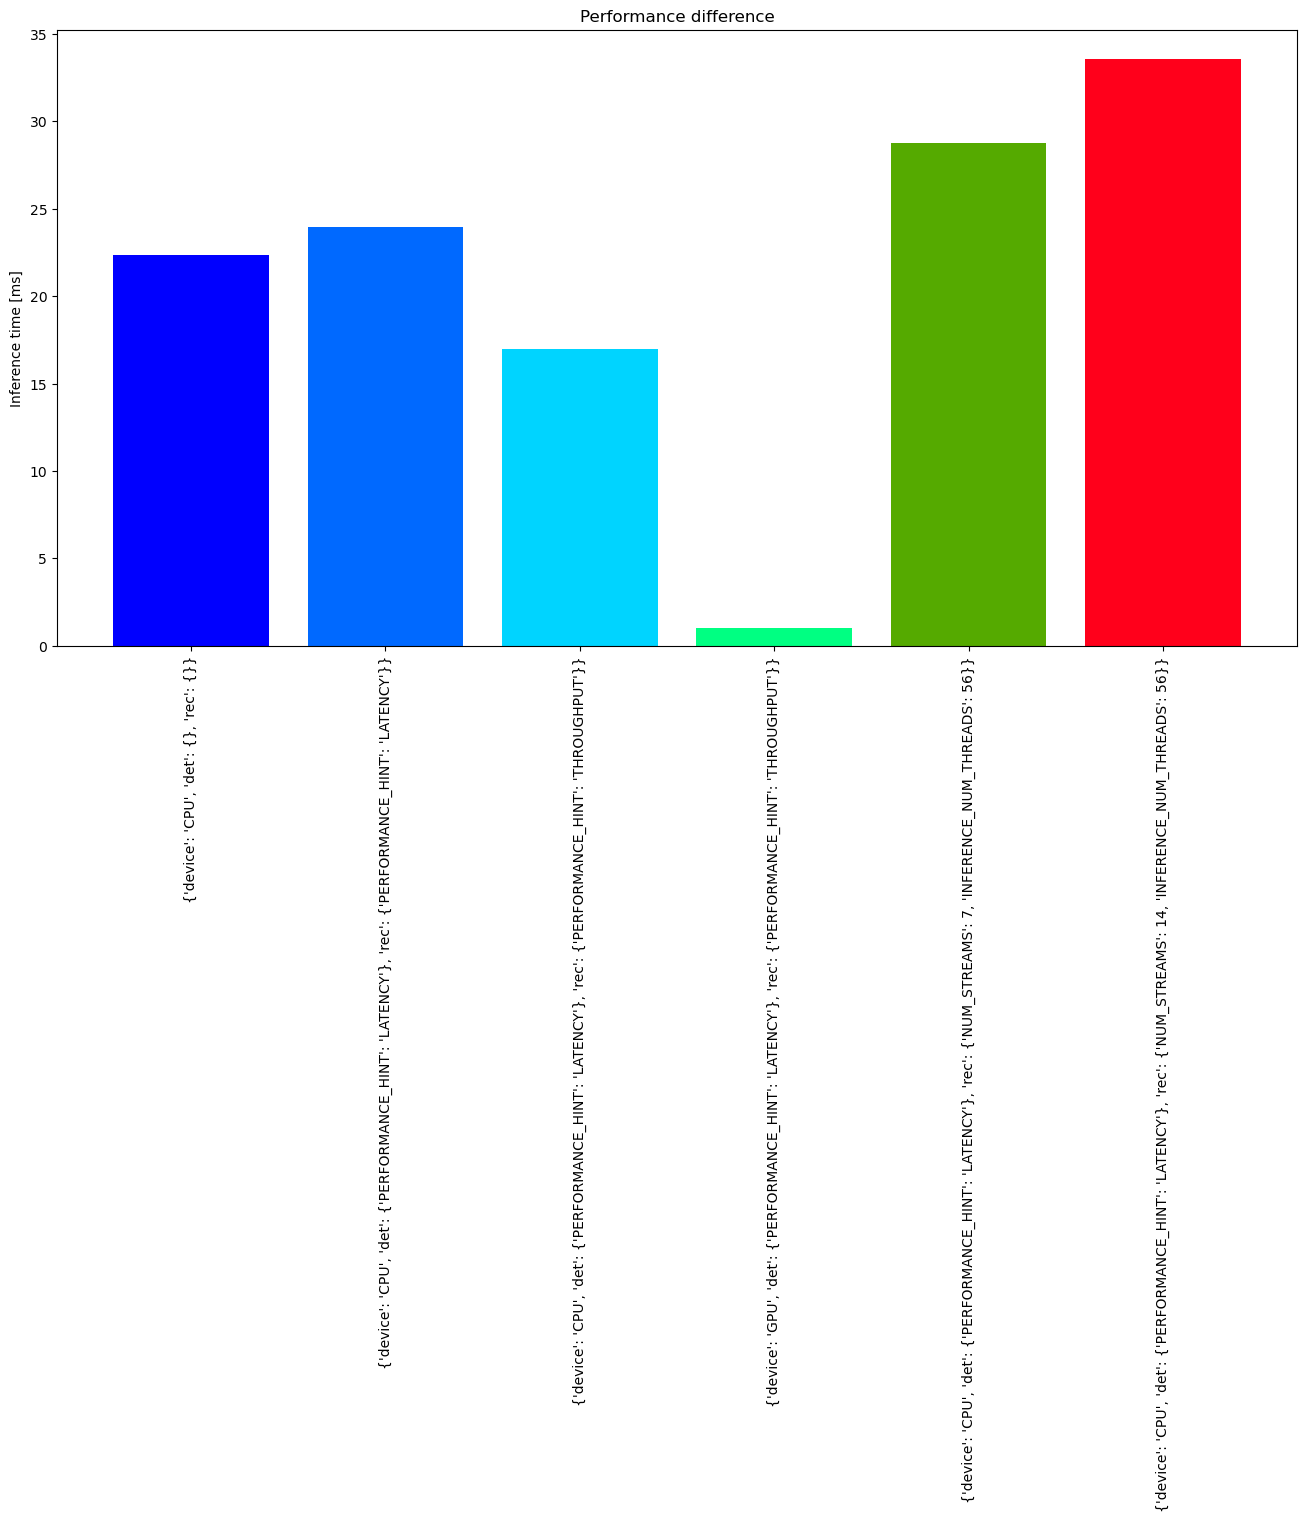

In [24]:
from matplotlib import pyplot as plt

bar_colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(results), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(configs, results, color=bar_colors/ 255.0)

ax.set_ylabel("FPS")
ax.set_title("Performance difference")

plt.xticks(rotation='vertical')
plt.show()
configs = []
results = []